### Input networks from different data sources

In [1]:
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import datetime, pickle, subprocess
from networks import bio_networks, utils
from create_datasets import create_nx_datasets, create_splits

**1. Obtain genes of interest**

Using DisGeNET to get Gene-Disease-Associations (GDAs) to Alzheimer's Disease (AD gene set) and other neurodegenerative diseases (ND).

In [ ]:
subprocess.call ("genes_of_interest/get_GDAs.R")

**2. Obtain biological networks**

Obtain new biological networks for the AD gene set from different sources:
1. STRING: Protein-Protein Interactions (PPIs)
2. BioGRID: Protein-Protein Interactions (PPIs)
3. Human Reference Interactome (HuRI): PPIs
4. PPT-Ohmnet dataset from Stanford Network Analysis Project (SNAP): brain-specific PPIs
5. GIANT: functional network, brain-specific

In [ ]:
# STRING (PPI)
print('STRING')
edgelist_string = bio_networks.get_string('data/AD_GDAs.tsv')
print()

# BioGRID (PPI)
print('BioGRID')
edgelist_biogrid = bio_networks.get_biogrid('data/AD_GDAs.txt')
print()

# HuRI (PPI) - HuRI interactions were downloaded from HuRI webpage and then parsed to obtain the corresponding edgelist.
print('HuRI')
edgelist_huri = bio_networks.get_huri('data/other_networks/HuRI_download_interactions_dec_16_2021_11_54_03.csv')
print()

# PPT-Ohmnet (PPI, brain-specific)
print('PPT-Ohmnet')
network_snap = bio_networks.get_snap('data/AD_GDAs.txt')
print()

# GIANT (functional network, brain-specific)
print('GIANT')
network_giant = bio_networks.get_giant('data/AD_GDAs.txt')
print()

**2. Create graph datasets**

Create the correspoding graph-datasets for each newly obtained biological network.

In [ ]:
dataset = 'ADNI'
targets = ['PET', 'PETandDX']
networks = ['string', 'biogrid', 'huri', 'snap_brain', 'giant_brain']

for target in targets:
    for network in networks:

        outdir = f'data/graph_datasets/{target}'

        result_nodes = create_nx_datasets.main('data', dataset, target, 'AD', network, 'missense', None)
        outfile = f'{outdir}/AD_PPI_{network}_missense.pkl'
        print('Resulting dataset saved at:', outfile)
        print()

        with open(outfile, 'wb') as f:
            pickle.dump(result_nodes, f)

In [ ]:
# Create splits for using it in GraphGym and non-GNN models
# Splits are obtained through 10-Fold Stratied Cross Validation

create_splits.create_folds_stratified_cv('PET', 10)
create_splits.create_folds_stratified_cv('PETandDX', 10)

**3. Graph classification with GNNs**

We then evaluated and tested different GNNs in the framework called [GraphGym](https://github.com/snap-stanford/GraphGym) (You *et al.*, 2020).

Configuration and grid files employed are in the subdirectory [graphgym_files](graphgym_files).

Summarized results obtained by GraphGym and other models are in **COMPLETE**

This section evaluates significance between the results that obtained different best GNN configs for each biological network.

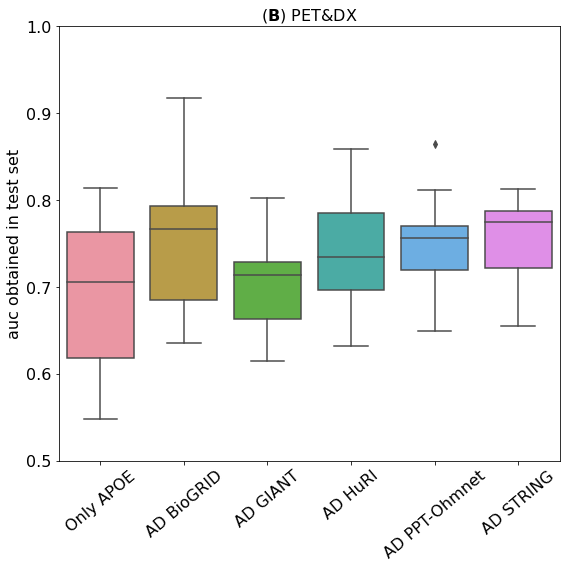

In [2]:
petdx_results = pd.read_csv('results/2022_03_networks_PETandDX.csv')
utils.barplot_comparision_others('PETandDX', petdx_results, 'auc', r"($\bf{B}$) PET&DX")

In [3]:
pvalues = utils.statistics(petdx_results)
print(pvalues)

{'AD PPT-Ohmnet': 0.051717255609973756, 'AD STRING': 0.05469058028620656, 'AD BioGRID': 0.06926328684824597, 'AD HuRI': 0.10254157203420601, 'AD GIANT': 0.3604574252913516, 'Only APOE': 0.5}
